# Bitcoin RNN Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
bitcoin_csv = os.path.join(current_folder, "data","bitcoin_hourly.csv")
bitcoin_df = pd.read_csv(bitcoin_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
bitcoin_df['highLowDif'] = bitcoin_df['highPriceUsd'] - bitcoin_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = bitcoin_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = bitcoin_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = bitcoin_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [2]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [3]:
bitcoin_df.iloc[0]

datetime                      2021-02-03 00:00:00+00:00
bitcoin_count                                      1557
bitcoin_polarity                               0.198884
bitcoin_subjectivity                           0.503805
bitcoin_polarity_zeros                         0.105064
bitcoin_subjectivity_zeros                     0.303084
openPriceUsd                                    35510.8
closePriceUsd                                   36119.5
highPriceUsd                                    36131.9
lowPriceUsd                                       35444
volume                                      62260118369
marketcap                                  672459334169
highLowDif                                      687.926
Name: 0, dtype: object

In [4]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'bitcoin_polarity', 'bitcoin_subjectivity', 'openPriceUsd',  'marketcap', 'highLowDif'])

In [5]:
timeperiod_df.iloc[0]

bitcoin_count                 1.557000e+03
bitcoin_polarity_zeros        1.050641e-01
bitcoin_subjectivity_zeros    3.030843e-01
closePriceUsd                 3.611949e+04
highPriceUsd                  3.613191e+04
lowPriceUsd                   3.544398e+04
volume                        6.226012e+10
Name: 0, dtype: float64

In [6]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples, validation_samples)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 1680th, validation: 2160th, test: 2400th
Input shape: (128, 120, 7)
Target shape: (128, 1)


Epoch 1/20
13/13 [==============================] - 6s 323ms/step - loss: 1.2686 - val_loss: 0.5836
Epoch 2/20
13/13 [==============================] - 3s 247ms/step - loss: 0.2744 - val_loss: 0.6645
Epoch 3/20
13/13 [==============================] - 3s 247ms/step - loss: 0.2331 - val_loss: 0.7409
Epoch 4/20
13/13 [==============================] - 4s 273ms/step - loss: 0.2352 - val_loss: 0.5870
Epoch 5/20
13/13 [==============================] - 3s 244ms/step - loss: 0.1915 - val_loss: 0.7288
Epoch 6/20
13/13 [==============================] - 3s 222ms/step - loss: 0.1922 - val_loss: 0.5074
Epoch 7/20
13/13 [==============================] - 4s 315ms/step - loss: 0.1686 - val_loss: 0.5289
Epoch 8/20
13/13 [==============================] - 4s 278ms/step - loss: 0.1580 - val_loss: 0.4441
Epoch 9/20
13/13 [==============================] - 3s 244ms/step - loss: 0.1435 - val_loss: 0.5209
Epoch 10/20
13/13 [==============================] - 4s 297ms/step - loss: 0.1336 - val_loss: 0.4409

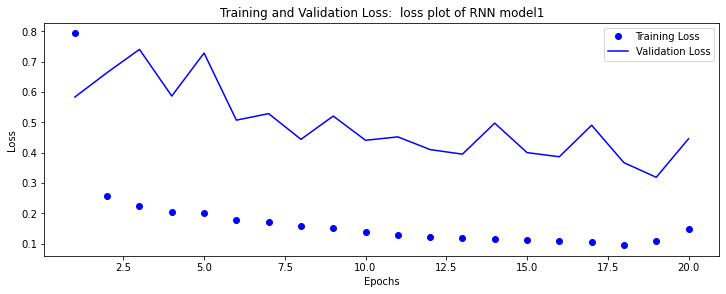

In [7]:
RNN_model1 = models.Sequential()
RNN_model1.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model1.add(layers.SimpleRNN(100))


RNN_model1.add(layers.Dense(1))

RNN_model1.compile(optimizer=RMSprop(), loss='mse')
RNN_model1_history = RNN_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model1_history, "loss plot of RNN model1")

Epoch 1/20
13/13 [==============================] - 6s 313ms/step - loss: 1.2745 - val_loss: 0.9757
Epoch 2/20
13/13 [==============================] - 4s 347ms/step - loss: 0.3646 - val_loss: 0.5484
Epoch 3/20
13/13 [==============================] - 4s 277ms/step - loss: 0.2588 - val_loss: 0.9398
Epoch 4/20
13/13 [==============================] - 4s 286ms/step - loss: 0.2746 - val_loss: 0.9395
Epoch 5/20
13/13 [==============================] - 4s 304ms/step - loss: 0.2526 - val_loss: 0.9592
Epoch 6/20
13/13 [==============================] - 4s 284ms/step - loss: 0.2378 - val_loss: 0.8753
Epoch 7/20
13/13 [==============================] - 4s 292ms/step - loss: 0.2249 - val_loss: 0.9297
Epoch 8/20
13/13 [==============================] - 4s 345ms/step - loss: 0.2165 - val_loss: 1.0485
Epoch 9/20
13/13 [==============================] - 4s 289ms/step - loss: 0.2236 - val_loss: 0.7822
Epoch 10/20
13/13 [==============================] - 4s 298ms/step - loss: 0.2032 - val_loss: 0.7065

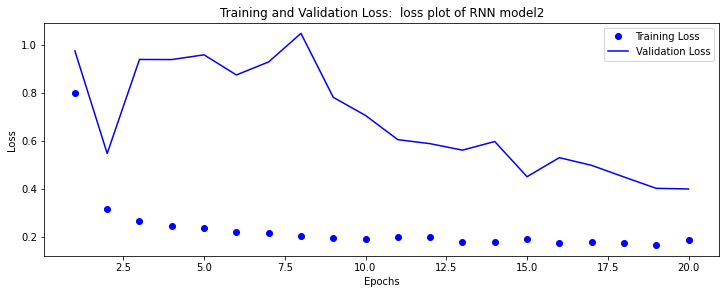

In [8]:
RNN_model2 = models.Sequential()
RNN_model2.add(layers.SimpleRNN(100, return_sequences=True,dropout=0.2, recurrent_dropout=0.2,input_shape=(shape_1, shape_2)))

RNN_model2.add(layers.SimpleRNN(100))


RNN_model2.add(layers.Dense(1))

RNN_model2.compile(optimizer=RMSprop(), loss='mse')
RNN_model2_history = RNN_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model2_history, "loss plot of RNN model2")

Epoch 1/30
13/13 [==============================] - 7s 319ms/step - loss: 0.6486 - val_loss: 0.8236
Epoch 2/30
13/13 [==============================] - 3s 266ms/step - loss: 0.3019 - val_loss: 0.6417
Epoch 3/30
13/13 [==============================] - 3s 213ms/step - loss: 0.2451 - val_loss: 0.5197
Epoch 4/30
13/13 [==============================] - 4s 309ms/step - loss: 0.2123 - val_loss: 0.4317
Epoch 5/30
13/13 [==============================] - 3s 266ms/step - loss: 0.1864 - val_loss: 0.3603
Epoch 6/30
13/13 [==============================] - 4s 281ms/step - loss: 0.1701 - val_loss: 0.3107
Epoch 7/30
13/13 [==============================] - 3s 225ms/step - loss: 0.1614 - val_loss: 0.2798
Epoch 8/30
13/13 [==============================] - 3s 268ms/step - loss: 0.1487 - val_loss: 0.2505
Epoch 9/30
13/13 [==============================] - 3s 221ms/step - loss: 0.1448 - val_loss: 0.2327
Epoch 10/30
13/13 [==============================] - 4s 298ms/step - loss: 0.1493 - val_loss: 0.2216

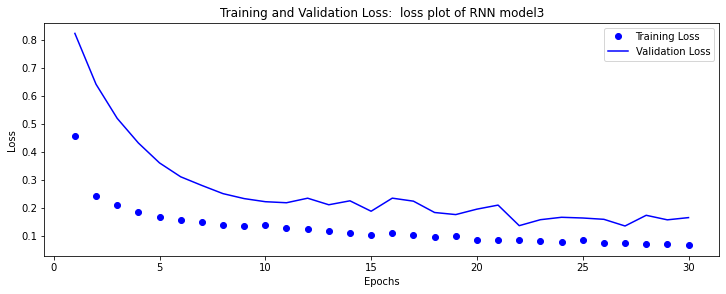

In [9]:
RNN_model3 = models.Sequential()
RNN_model3.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model3.add(layers.SimpleRNN(50))


RNN_model3.add(layers.Dense(1))

RNN_model3.compile(optimizer=RMSprop(), loss='mse')
RNN_model3_history = RNN_model3.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model3_history, "loss plot of RNN model3")

Epoch 1/30
13/13 [==============================] - 6s 333ms/step - loss: 0.8290 - val_loss: 1.2140
Epoch 2/30
13/13 [==============================] - 4s 279ms/step - loss: 0.3523 - val_loss: 0.9526
Epoch 3/30
13/13 [==============================] - 4s 296ms/step - loss: 0.3100 - val_loss: 0.8821
Epoch 4/30
13/13 [==============================] - 4s 302ms/step - loss: 0.2731 - val_loss: 1.0550
Epoch 5/30
13/13 [==============================] - 5s 398ms/step - loss: 0.2533 - val_loss: 1.1261
Epoch 6/30
13/13 [==============================] - 3s 261ms/step - loss: 0.2549 - val_loss: 1.1208
Epoch 7/30
13/13 [==============================] - 4s 317ms/step - loss: 0.2325 - val_loss: 1.0137
Epoch 8/30
13/13 [==============================] - 4s 342ms/step - loss: 0.2194 - val_loss: 0.9342
Epoch 9/30
13/13 [==============================] - 3s 254ms/step - loss: 0.2038 - val_loss: 0.8674
Epoch 10/30
13/13 [==============================] - 5s 397ms/step - loss: 0.1939 - val_loss: 0.8500

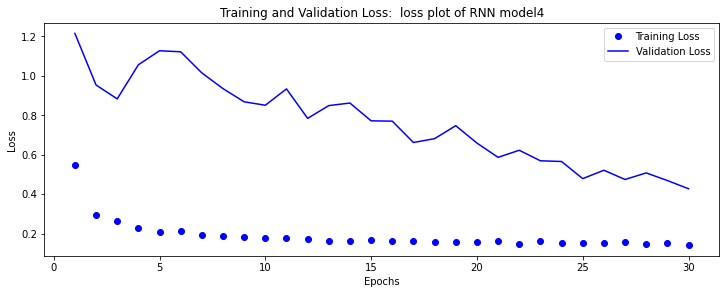

In [10]:
RNN_model4 = models.Sequential()
RNN_model4.add(layers.SimpleRNN(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model4.add(layers.SimpleRNN(50))


RNN_model4.add(layers.Dense(1))

RNN_model4.compile(optimizer=RMSprop(), loss='mse')
RNN_model4_history = RNN_model4.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model4_history, "loss plot of RNN model4")

Epoch 1/30
13/13 [==============================] - 5s 215ms/step - loss: 0.6414 - val_loss: 0.5728
Epoch 2/30
13/13 [==============================] - 2s 182ms/step - loss: 0.2487 - val_loss: 0.4476
Epoch 3/30
13/13 [==============================] - 2s 184ms/step - loss: 0.2030 - val_loss: 0.3817
Epoch 4/30
13/13 [==============================] - 4s 280ms/step - loss: 0.1808 - val_loss: 0.3478
Epoch 5/30
13/13 [==============================] - 3s 201ms/step - loss: 0.1701 - val_loss: 0.3456
Epoch 6/30
13/13 [==============================] - 2s 176ms/step - loss: 0.1622 - val_loss: 0.3511
Epoch 7/30
13/13 [==============================] - 2s 193ms/step - loss: 0.1585 - val_loss: 0.3500
Epoch 8/30
13/13 [==============================] - 2s 177ms/step - loss: 0.1572 - val_loss: 0.3416
Epoch 9/30
13/13 [==============================] - 2s 176ms/step - loss: 0.1559 - val_loss: 0.3309
Epoch 10/30
13/13 [==============================] - 3s 177ms/step - loss: 0.1524 - val_loss: 0.3555

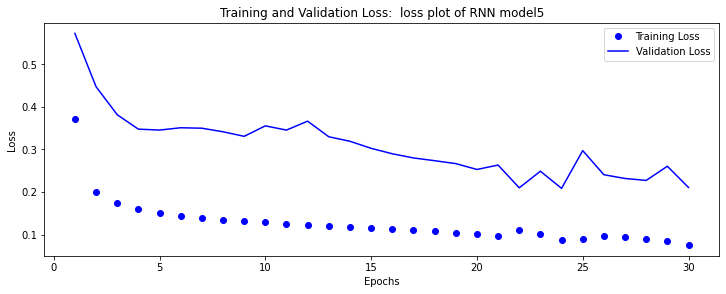

In [11]:
RNN_model5 = models.Sequential()
RNN_model5.add(layers.SimpleRNN(50, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model5.add(layers.SimpleRNN(50))


RNN_model5.add(layers.Dense(1))

RNN_model5.compile(optimizer=RMSprop(), loss='mse')
RNN_model5_history = RNN_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model5_history, "loss plot of RNN model5")

Epoch 1/30
13/13 [==============================] - 7s 311ms/step - loss: 0.6921 - val_loss: 0.9324
Epoch 2/30
13/13 [==============================] - 4s 289ms/step - loss: 0.3109 - val_loss: 1.1523
Epoch 3/30
13/13 [==============================] - 3s 272ms/step - loss: 0.2898 - val_loss: 1.3722
Epoch 4/30
13/13 [==============================] - 3s 210ms/step - loss: 0.2835 - val_loss: 1.1162
Epoch 5/30
13/13 [==============================] - 3s 211ms/step - loss: 0.2314 - val_loss: 1.1108
Epoch 6/30
13/13 [==============================] - 3s 264ms/step - loss: 0.2278 - val_loss: 0.9602
Epoch 7/30
13/13 [==============================] - 3s 205ms/step - loss: 0.2144 - val_loss: 1.0567
Epoch 8/30
13/13 [==============================] - 3s 195ms/step - loss: 0.2080 - val_loss: 0.9002
Epoch 9/30
13/13 [==============================] - 3s 254ms/step - loss: 0.2040 - val_loss: 1.0531
Epoch 10/30
13/13 [==============================] - 3s 201ms/step - loss: 0.2089 - val_loss: 0.9429

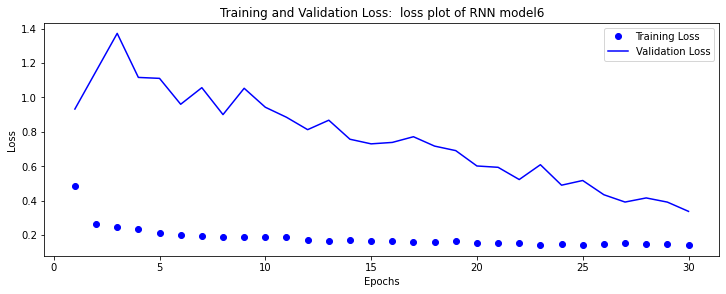

In [12]:
RNN_model6 = models.Sequential()
RNN_model6.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model6.add(layers.SimpleRNN(50))


RNN_model6.add(layers.Dense(1))

RNN_model6.compile(optimizer=RMSprop(), loss='mse')
RNN_model6_history = RNN_model6.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model6_history, "loss plot of RNN model6")

Epoch 1/40
13/13 [==============================] - 5s 167ms/step - loss: 0.9533 - val_loss: 0.4639
Epoch 2/40
13/13 [==============================] - 2s 162ms/step - loss: 0.2427 - val_loss: 0.3803
Epoch 3/40
13/13 [==============================] - 2s 158ms/step - loss: 0.2033 - val_loss: 0.3362
Epoch 4/40
13/13 [==============================] - 2s 155ms/step - loss: 0.1797 - val_loss: 0.2986
Epoch 5/40
13/13 [==============================] - 2s 161ms/step - loss: 0.1628 - val_loss: 0.2699
Epoch 6/40
13/13 [==============================] - 2s 157ms/step - loss: 0.1511 - val_loss: 0.2503
Epoch 7/40
13/13 [==============================] - 2s 152ms/step - loss: 0.1426 - val_loss: 0.2374
Epoch 8/40
13/13 [==============================] - 2s 155ms/step - loss: 0.1355 - val_loss: 0.2274
Epoch 9/40
13/13 [==============================] - 2s 153ms/step - loss: 0.1291 - val_loss: 0.2185
Epoch 10/40
13/13 [==============================] - 2s 160ms/step - loss: 0.1234 - val_loss: 0.2101

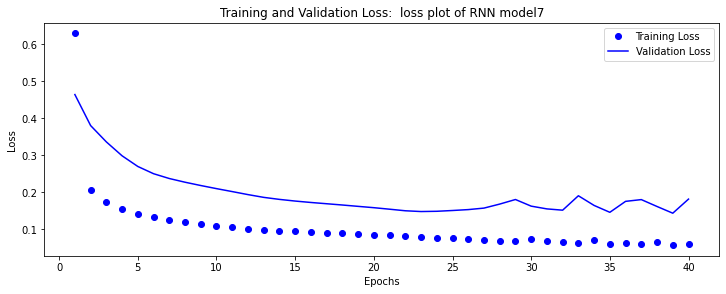

In [13]:
RNN_model7 = models.Sequential()
RNN_model7.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model7.add(layers.SimpleRNN(32))


RNN_model7.add(layers.Dense(1))

RNN_model7.compile(optimizer=RMSprop(), loss='mse')
RNN_model7_history = RNN_model7.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model7_history, "loss plot of RNN model7")

Epoch 1/30
13/13 [==============================] - 6s 268ms/step - loss: 0.5298 - val_loss: 0.7015
Epoch 2/30
13/13 [==============================] - 2s 176ms/step - loss: 0.2879 - val_loss: 0.5890
Epoch 3/30
13/13 [==============================] - 2s 184ms/step - loss: 0.2461 - val_loss: 0.5676
Epoch 4/30
13/13 [==============================] - 3s 228ms/step - loss: 0.2149 - val_loss: 0.5186
Epoch 5/30
13/13 [==============================] - 3s 267ms/step - loss: 0.1915 - val_loss: 0.5172
Epoch 6/30
13/13 [==============================] - 3s 243ms/step - loss: 0.1942 - val_loss: 0.4860
Epoch 7/30
13/13 [==============================] - 3s 231ms/step - loss: 0.1800 - val_loss: 0.4738
Epoch 8/30
13/13 [==============================] - 2s 176ms/step - loss: 0.1888 - val_loss: 0.4182
Epoch 9/30
13/13 [==============================] - 3s 198ms/step - loss: 0.1730 - val_loss: 0.4742
Epoch 10/30
13/13 [==============================] - 3s 212ms/step - loss: 0.1793 - val_loss: 0.4197

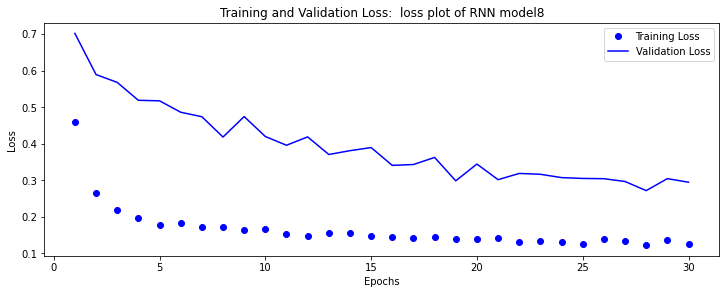

In [14]:
RNN_model8 = models.Sequential()
RNN_model8.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model8.add(layers.SimpleRNN(32))


RNN_model8.add(layers.Dense(1))

RNN_model8.compile(optimizer=RMSprop(), loss='mse')
RNN_model8_history = RNN_model8.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model8_history, "loss plot of RNN model8")

Epoch 1/20
13/13 [==============================] - 4s 186ms/step - loss: 0.5565 - val_loss: 0.4361
Epoch 2/20
13/13 [==============================] - 2s 157ms/step - loss: 0.2690 - val_loss: 0.3530
Epoch 3/20
13/13 [==============================] - 2s 163ms/step - loss: 0.2152 - val_loss: 0.3149
Epoch 4/20
13/13 [==============================] - 3s 190ms/step - loss: 0.1875 - val_loss: 0.2948
Epoch 5/20
13/13 [==============================] - 2s 167ms/step - loss: 0.1685 - val_loss: 0.2872
Epoch 6/20
13/13 [==============================] - 2s 151ms/step - loss: 0.1538 - val_loss: 0.2828
Epoch 7/20
13/13 [==============================] - 2s 163ms/step - loss: 0.1419 - val_loss: 0.2700
Epoch 8/20
13/13 [==============================] - 2s 166ms/step - loss: 0.1327 - val_loss: 0.2667
Epoch 9/20
13/13 [==============================] - 2s 158ms/step - loss: 0.1272 - val_loss: 0.2494
Epoch 10/20
13/13 [==============================] - 2s 151ms/step - loss: 0.1212 - val_loss: 0.2537

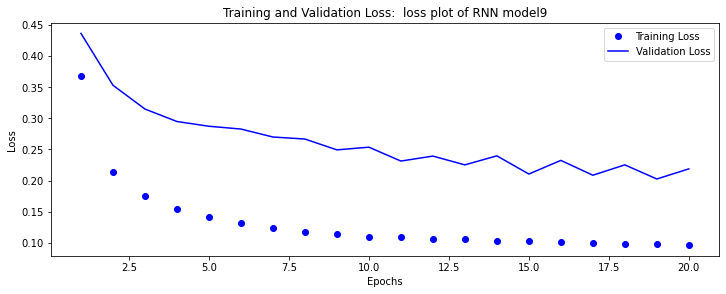

In [15]:
RNN_model9 = models.Sequential()
RNN_model9.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model9.add(layers.SimpleRNN(16))


RNN_model9.add(layers.Dense(1))

RNN_model9.compile(optimizer=RMSprop(), loss='mse')
RNN_model9_history = RNN_model9.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model9_history, "loss plot of RNN model9")

Epoch 1/20
13/13 [==============================] - 6s 244ms/step - loss: 0.5658 - val_loss: 0.5370
Epoch 2/20
13/13 [==============================] - 2s 180ms/step - loss: 0.3382 - val_loss: 0.4566
Epoch 3/20
13/13 [==============================] - 3s 232ms/step - loss: 0.2753 - val_loss: 0.4638
Epoch 4/20
13/13 [==============================] - 2s 163ms/step - loss: 0.2564 - val_loss: 0.4336
Epoch 5/20
13/13 [==============================] - 3s 215ms/step - loss: 0.2230 - val_loss: 0.4249
Epoch 6/20
13/13 [==============================] - 2s 181ms/step - loss: 0.2185 - val_loss: 0.3831
Epoch 7/20
13/13 [==============================] - 2s 182ms/step - loss: 0.2063 - val_loss: 0.3999
Epoch 8/20
13/13 [==============================] - 2s 185ms/step - loss: 0.2053 - val_loss: 0.3854
Epoch 9/20
13/13 [==============================] - 3s 207ms/step - loss: 0.1888 - val_loss: 0.3874
Epoch 10/20
13/13 [==============================] - 3s 243ms/step - loss: 0.1977 - val_loss: 0.3526

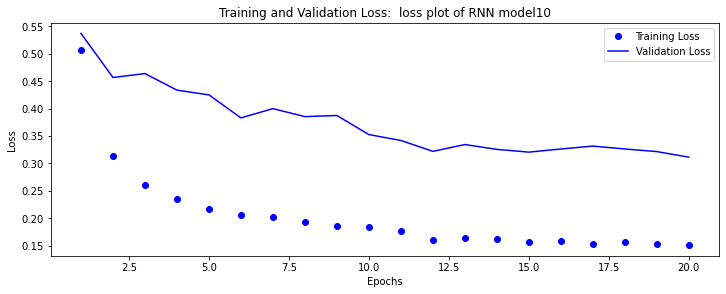

In [16]:
RNN_model10 = models.Sequential()
RNN_model10.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model10.add(layers.SimpleRNN(16))

RNN_model10.add(layers.Dense(1))

RNN_model10.compile(optimizer=RMSprop(), loss='mse')
RNN_model10_history = RNN_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model10_history, "loss plot of RNN model10")

Epoch 1/40
13/13 [==============================] - 6s 208ms/step - loss: 0.5166 - val_loss: 0.3322
Epoch 2/40
13/13 [==============================] - 2s 167ms/step - loss: 0.3375 - val_loss: 0.3030
Epoch 3/40
13/13 [==============================] - 2s 167ms/step - loss: 0.3194 - val_loss: 0.2946
Epoch 4/40
13/13 [==============================] - 3s 206ms/step - loss: 0.2630 - val_loss: 0.2981
Epoch 5/40
13/13 [==============================] - 2s 173ms/step - loss: 0.2125 - val_loss: 0.3134
Epoch 6/40
13/13 [==============================] - 2s 190ms/step - loss: 0.2233 - val_loss: 0.3159
Epoch 7/40
13/13 [==============================] - 2s 167ms/step - loss: 0.2031 - val_loss: 0.3247
Epoch 8/40
13/13 [==============================] - 3s 227ms/step - loss: 0.1966 - val_loss: 0.3211
Epoch 9/40
13/13 [==============================] - 2s 163ms/step - loss: 0.1811 - val_loss: 0.3163
Epoch 10/40
13/13 [==============================] - 2s 154ms/step - loss: 0.1875 - val_loss: 0.3166

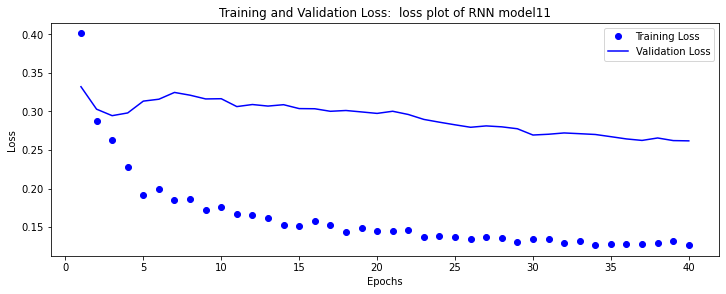

In [17]:
RNN_model11 = models.Sequential()
RNN_model11.add(layers.SimpleRNN(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model11.add(layers.SimpleRNN(5))


RNN_model11.add(layers.Dense(1))

RNN_model11.compile(optimizer=RMSprop(), loss='mse')
RNN_model11_history = RNN_model11.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model11_history, "loss plot of RNN model11")

Epoch 1/30
13/13 [==============================] - 10s 358ms/step - loss: 0.9411 - val_loss: 2.1326
Epoch 2/30
13/13 [==============================] - 4s 286ms/step - loss: 0.4493 - val_loss: 1.5846
Epoch 3/30
13/13 [==============================] - 5s 366ms/step - loss: 0.3064 - val_loss: 1.2825
Epoch 4/30
13/13 [==============================] - 4s 300ms/step - loss: 0.2737 - val_loss: 1.2009
Epoch 5/30
13/13 [==============================] - 5s 399ms/step - loss: 0.2668 - val_loss: 1.1910
Epoch 6/30
13/13 [==============================] - 3s 249ms/step - loss: 0.2503 - val_loss: 1.1065
Epoch 7/30
13/13 [==============================] - 3s 233ms/step - loss: 0.2430 - val_loss: 1.1177
Epoch 8/30
13/13 [==============================] - 5s 360ms/step - loss: 0.2249 - val_loss: 1.0051
Epoch 9/30
13/13 [==============================] - 3s 259ms/step - loss: 0.2256 - val_loss: 1.0861
Epoch 10/30
13/13 [==============================] - 4s 280ms/step - loss: 0.2392 - val_loss: 1.038

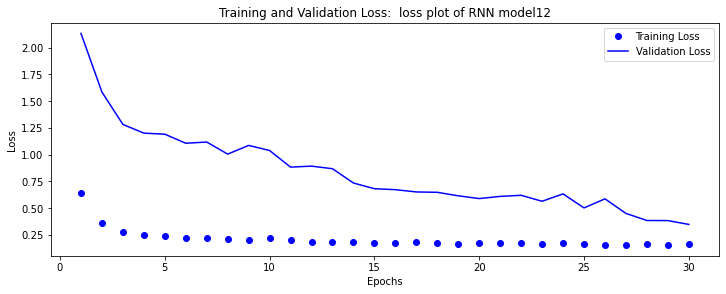

In [18]:
RNN_model12 = models.Sequential()
RNN_model12.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model12.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))

RNN_model12.add(layers.SimpleRNN(50))


RNN_model12.add(layers.Dense(1))

RNN_model12.compile(optimizer=RMSprop(), loss='mse')
RNN_model12_history = RNN_model12.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model12_history, "loss plot of RNN model12")

Epoch 1/30
13/13 [==============================] - 7s 319ms/step - loss: 0.7817 - val_loss: 2.7328
Epoch 2/30
13/13 [==============================] - 4s 272ms/step - loss: 0.4968 - val_loss: 1.9195
Epoch 3/30
13/13 [==============================] - 5s 375ms/step - loss: 0.3612 - val_loss: 1.7440
Epoch 4/30
13/13 [==============================] - 4s 289ms/step - loss: 0.3227 - val_loss: 1.5568
Epoch 5/30
13/13 [==============================] - 4s 288ms/step - loss: 0.2837 - val_loss: 1.6505
Epoch 6/30
13/13 [==============================] - 4s 281ms/step - loss: 0.2787 - val_loss: 1.5410
Epoch 7/30
13/13 [==============================] - 4s 275ms/step - loss: 0.2659 - val_loss: 1.3514
Epoch 8/30
13/13 [==============================] - 4s 289ms/step - loss: 0.2708 - val_loss: 1.6045
Epoch 9/30
13/13 [==============================] - 5s 368ms/step - loss: 0.2567 - val_loss: 1.1097
Epoch 10/30
13/13 [==============================] - 5s 405ms/step - loss: 0.2425 - val_loss: 1.0744

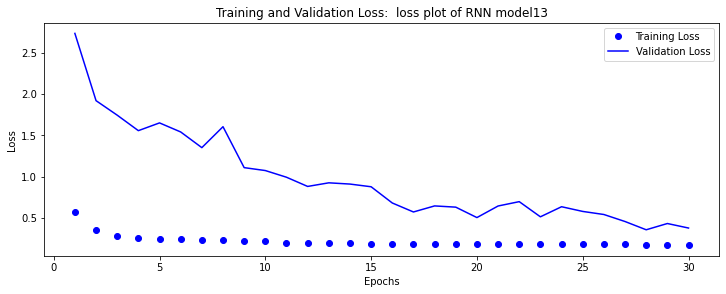

In [19]:
RNN_model13 = models.Sequential()
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50))


RNN_model13.add(layers.Dense(1))

RNN_model13.compile(optimizer=RMSprop(), loss='mse')
RNN_model13_history = RNN_model13.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model13_history, "loss plot of RNN model13")

Epoch 1/20
13/13 [==============================] - 5s 171ms/step - loss: 0.4481 - val_loss: 0.7938
Epoch 2/20
13/13 [==============================] - 2s 173ms/step - loss: 0.2758 - val_loss: 0.5644
Epoch 3/20
13/13 [==============================] - 2s 156ms/step - loss: 0.2019 - val_loss: 0.5005
Epoch 4/20
13/13 [==============================] - 2s 147ms/step - loss: 0.1755 - val_loss: 0.4464
Epoch 5/20
13/13 [==============================] - 3s 204ms/step - loss: 0.1632 - val_loss: 0.4018
Epoch 6/20
13/13 [==============================] - 3s 222ms/step - loss: 0.1521 - val_loss: 0.3876
Epoch 7/20
13/13 [==============================] - 2s 153ms/step - loss: 0.1405 - val_loss: 0.3598
Epoch 8/20
13/13 [==============================] - 2s 141ms/step - loss: 0.1324 - val_loss: 0.3722
Epoch 9/20
13/13 [==============================] - 2s 151ms/step - loss: 0.1236 - val_loss: 0.3386
Epoch 10/20
13/13 [==============================] - 2s 147ms/step - loss: 0.1205 - val_loss: 0.3196

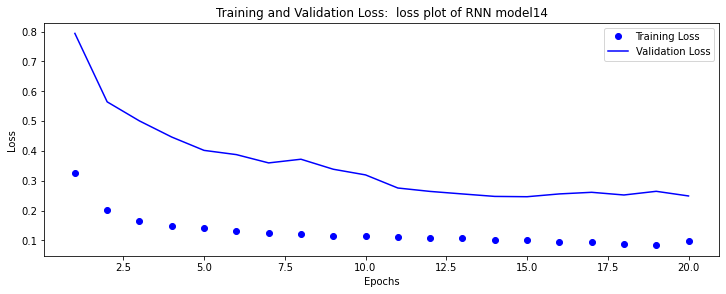

In [20]:
RNN_model14 = models.Sequential()
RNN_model14.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model14.add(layers.SimpleRNN(32))

RNN_model14.add(layers.Dense(1))

RNN_model14.compile(optimizer=RMSprop(), loss='mse')
RNN_model14_history = RNN_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model14_history, "loss plot of RNN model14")

Epoch 1/20
13/13 [==============================] - 3s 161ms/step - loss: 0.4044 - val_loss: 0.2032
Epoch 2/20
13/13 [==============================] - 2s 133ms/step - loss: 0.1840 - val_loss: 0.2599
Epoch 3/20
13/13 [==============================] - 2s 132ms/step - loss: 0.1826 - val_loss: 0.2694
Epoch 4/20
13/13 [==============================] - 2s 185ms/step - loss: 0.1786 - val_loss: 0.2591
Epoch 5/20
13/13 [==============================] - 2s 191ms/step - loss: 0.1718 - val_loss: 0.2437
Epoch 6/20
13/13 [==============================] - 2s 125ms/step - loss: 0.1647 - val_loss: 0.2275
Epoch 7/20
13/13 [==============================] - 2s 132ms/step - loss: 0.1579 - val_loss: 0.2122
Epoch 8/20
13/13 [==============================] - 2s 127ms/step - loss: 0.1517 - val_loss: 0.1984
Epoch 9/20
13/13 [==============================] - 2s 170ms/step - loss: 0.1461 - val_loss: 0.1865
Epoch 10/20
13/13 [==============================] - 3s 270ms/step - loss: 0.1414 - val_loss: 0.1765

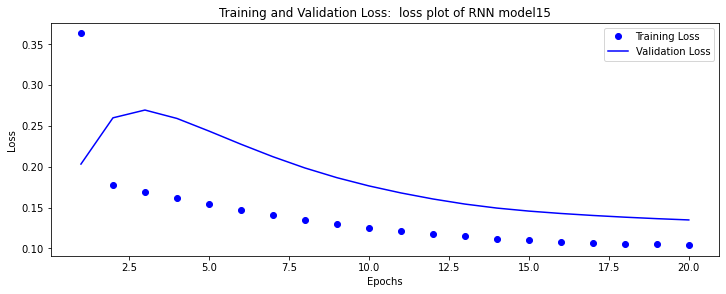

In [21]:
RNN_model15 = models.Sequential()
RNN_model15.add(layers.SimpleRNN(16, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model15.add(layers.SimpleRNN(16))

RNN_model15.add(layers.Dense(1))

RNN_model15.compile(optimizer=RMSprop(), loss='mse')
RNN_model15_history = RNN_model15.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model15_history, "loss plot of RNN model15")

Epoch 1/20
13/13 [==============================] - 5s 192ms/step - loss: 0.7847 - val_loss: 0.4832
Epoch 2/20
13/13 [==============================] - 2s 164ms/step - loss: 0.2461 - val_loss: 0.3951
Epoch 3/20
13/13 [==============================] - 4s 287ms/step - loss: 0.1982 - val_loss: 0.4100
Epoch 4/20
13/13 [==============================] - 3s 256ms/step - loss: 0.1871 - val_loss: 0.3983
Epoch 5/20
13/13 [==============================] - 2s 155ms/step - loss: 0.1711 - val_loss: 0.3737
Epoch 6/20
13/13 [==============================] - 2s 186ms/step - loss: 0.1566 - val_loss: 0.3520
Epoch 7/20
13/13 [==============================] - 3s 202ms/step - loss: 0.1440 - val_loss: 0.3395
Epoch 8/20
13/13 [==============================] - 2s 162ms/step - loss: 0.1345 - val_loss: 0.3378
Epoch 9/20
13/13 [==============================] - 3s 247ms/step - loss: 0.1261 - val_loss: 0.3299
Epoch 10/20
13/13 [==============================] - 2s 175ms/step - loss: 0.1203 - val_loss: 0.3104

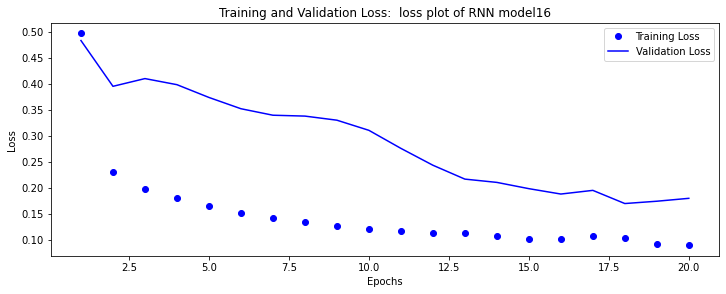

In [22]:
RNN_model16 = models.Sequential()
RNN_model16.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model16.add(layers.SimpleRNN(64))

RNN_model16.add(layers.Dense(1))

RNN_model16.compile(optimizer=RMSprop(), loss='mse')
RNN_model16_history = RNN_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model16_history, "loss plot of RNN model16")

Epoch 1/20
13/13 [==============================] - 7s 283ms/step - loss: 0.5656 - val_loss: 0.9415
Epoch 2/20
13/13 [==============================] - 3s 197ms/step - loss: 0.2900 - val_loss: 0.7875
Epoch 3/20
13/13 [==============================] - 2s 183ms/step - loss: 0.2230 - val_loss: 0.7840
Epoch 4/20
13/13 [==============================] - 3s 213ms/step - loss: 0.1980 - val_loss: 0.7155
Epoch 5/20
13/13 [==============================] - 3s 218ms/step - loss: 0.1793 - val_loss: 0.6725
Epoch 6/20
13/13 [==============================] - 3s 205ms/step - loss: 0.1745 - val_loss: 0.6535
Epoch 7/20
13/13 [==============================] - 3s 204ms/step - loss: 0.1579 - val_loss: 0.5969
Epoch 8/20
13/13 [==============================] - 3s 228ms/step - loss: 0.1531 - val_loss: 0.5866
Epoch 9/20
13/13 [==============================] - 3s 229ms/step - loss: 0.1428 - val_loss: 0.5362
Epoch 10/20
13/13 [==============================] - 2s 188ms/step - loss: 0.1363 - val_loss: 0.5645

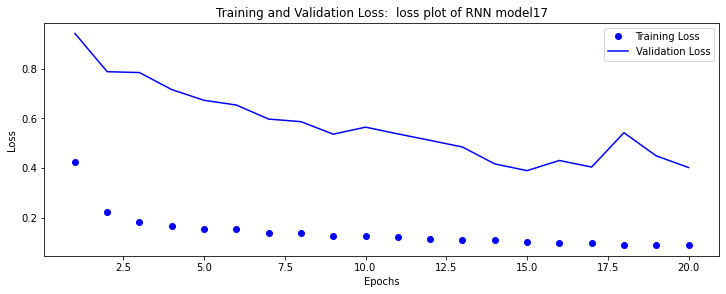

In [23]:
RNN_model17 = models.Sequential()
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32))
RNN_model17.add(layers.Dense(1))

RNN_model17.compile(optimizer=RMSprop(), loss='mse')
RNN_model17_history = RNN_model17.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model17_history, "loss plot of RNN model17")

Epoch 1/20
13/13 [==============================] - 6s 176ms/step - loss: 0.5233 - val_loss: 0.4623
Epoch 2/20
13/13 [==============================] - 2s 152ms/step - loss: 0.1939 - val_loss: 0.4220
Epoch 3/20
13/13 [==============================] - 2s 162ms/step - loss: 0.1609 - val_loss: 0.4048
Epoch 4/20
13/13 [==============================] - 2s 166ms/step - loss: 0.1460 - val_loss: 0.3788
Epoch 5/20
13/13 [==============================] - 3s 208ms/step - loss: 0.1374 - val_loss: 0.3525
Epoch 6/20
13/13 [==============================] - 3s 217ms/step - loss: 0.1321 - val_loss: 0.3391
Epoch 7/20
13/13 [==============================] - 3s 238ms/step - loss: 0.1278 - val_loss: 0.3306
Epoch 8/20
13/13 [==============================] - 2s 151ms/step - loss: 0.1240 - val_loss: 0.3217
Epoch 9/20
13/13 [==============================] - 2s 179ms/step - loss: 0.1204 - val_loss: 0.3126
Epoch 10/20
13/13 [==============================] - 2s 158ms/step - loss: 0.1169 - val_loss: 0.3041

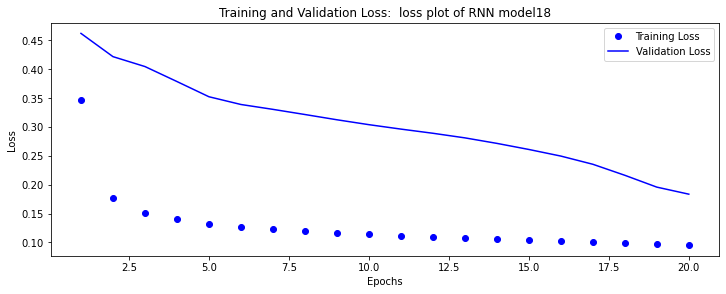

In [24]:
RNN_model18 = models.Sequential()
RNN_model18.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model18.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model18.add(layers.SimpleRNN(32))

RNN_model18.add(layers.Dense(1))

RNN_model18.compile(optimizer=RMSprop(), loss='mse')
RNN_model18_history = RNN_model18.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model18_history, "loss plot of RNN model18")

In [28]:
histories = [RNN_model1_history, RNN_model2_history, RNN_model3_history, RNN_model4_history, RNN_model5_history, RNN_model6_history, RNN_model7_history, RNN_model8_history, RNN_model9_history, RNN_model10_history, RNN_model11_history, RNN_model12_history, RNN_model13_history, RNN_model14_history, RNN_model15_history, RNN_model16_history, RNN_model17_history, RNN_model18_history]

for i in range(0, len(histories)):
    val_loss, epoch = lowest_val_loss_and_epoch(histories[i])
    print(f"Model {i+1}: min val loss: {val_loss}, epoch: {epoch}")

Model 1: min val loss: 0.3187912702560425, epoch: 19
Model 2: min val loss: 0.4003623127937317, epoch: 20
Model 3: min val loss: 0.1346980780363083, epoch: 27
Model 4: min val loss: 0.4269901216030121, epoch: 30
Model 5: min val loss: 0.20862050354480743, epoch: 24
Model 6: min val loss: 0.3376208543777466, epoch: 30
Model 7: min val loss: 0.1438237577676773, epoch: 39
Model 8: min val loss: 0.27172812819480896, epoch: 28
Model 9: min val loss: 0.20268458127975464, epoch: 19
Model 10: min val loss: 0.3115498125553131, epoch: 20
Model 11: min val loss: 0.2618609368801117, epoch: 40
Model 12: min val loss: 0.3481604754924774, epoch: 30
Model 13: min val loss: 0.358262836933136, epoch: 28
Model 14: min val loss: 0.2465459406375885, epoch: 15
Model 15: min val loss: 0.13476485013961792, epoch: 20
Model 16: min val loss: 0.16952186822891235, epoch: 18
Model 17: min val loss: 0.3896614611148834, epoch: 15
Model 18: min val loss: 0.1836579293012619, epoch: 20
